In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import ensemble
from matplotlib import style
from sklearn.ensemble import VotingRegressor

import datetime # для работы со времнем
import gc 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

style.use('fivethirtyeight')
%matplotlib inline



**1.Загрузка данных.**

In [3]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

test_data = pd.read_csv(TEST_DATASET_PATH)
train_data = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv(TEST_DATASET_PATH)

# test DATA
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк всего в train:' ,  X.shape[0])
print('Строк всего в test', X_final.shape[0])

Строк всего в train: 10000
Строк всего в test 5000


In [5]:
X_final.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
868,38,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,B,B,15,2787,2,520.0,0,7,B
672,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
2471,2,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,B,B,33,7425,1,NaN,2,5,B
4510,1,1.0,43.153761,21.017596,9.0,10,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B


In [6]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [7]:
X.head(8)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B
5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B
8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B
13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B


2.EDA

In [8]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**3.Обработка выбросов.**

In [9]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

1. **Rooms**

In [10]:
X['Rooms'].value_counts()
# Считаем выбросами количество комнат > 6 комнат и количество комнат = 0

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

2. **KitchenSquare**

In [11]:
X['KitchenSquare'].value_counts().sort_values()
# Считаем выбросами Площадь < 3 и Площадь KitchenSquare > 30 м2

75.0         1
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
2014.0       1
66.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
31.0         1
62.0         1
30.0         2
25.0         2
43.0         2
32.0         2
37.0         2
58.0         2
51.0         2
112.0        2
41.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

3. **HouseFloor**

In [12]:
X['HouseFloor'].sort_values().unique()  # количество этажей в доме

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [13]:
np.around(X['HouseFloor']).value_counts().sort_values()
# Считаем выбросами Площадь HouseFloor < 1 и HouseFloor > 50

26.0        1
29.0        1
44.0        1
47.0        1
45.0        1
31.0        1
38.0        1
117.0       1
36.0        1
39.0        2
99.0        2
48.0        2
28.0        3
32.0        4
37.0        4
27.0        6
40.0        7
30.0       21
13.0       27
11.0       28
21.0       33
23.0       40
2.0        48
6.0        58
7.0        59
18.0       89
20.0      105
19.0      108
15.0      123
3.0       127
4.0       134
10.0      135
8.0       141
24.0      176
0.0       269
22.0      343
25.0      374
1.0       497
16.0      576
14.0      625
5.0      1031
12.0     1074
9.0      1389
17.0     2331
Name: HouseFloor, dtype: int64

4. **Floor**

In [14]:
X['Floor'].value_counts().sort_values() # этаж

31      1
37      1
42      1
33      1
32      2
28      3
27      5
26     18
23     25
25     34
24     53
22     54
21     59
20     68
19    121
18    185
1     235
17    256
15    287
16    290
14    362
13    398
12    438
11    457
10    553
2     588
9     604
8     643
7     759
6     802
3     872
5     876
4     949
Name: Floor, dtype: int64

In [15]:
(X['Floor'] > X['HouseFloor']).sum()

1825

5. **HouseYear**

In [16]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [17]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B


**4.Обработка пропусков.**

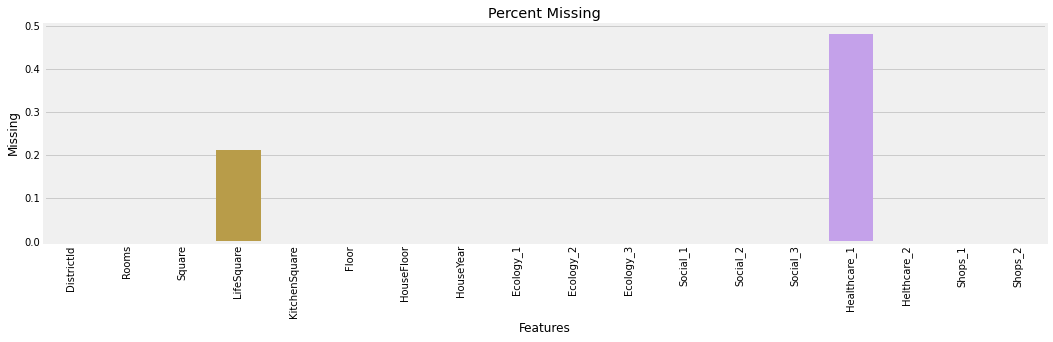

In [18]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Из-за большого кол-ва пропусков необходимо удалить признак Healthcare_1. Также необходимо заполнить признак LifeSquare.

**DistrictId**

In [19]:
X.DistrictId.nunique()

205

In [20]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '101': 97,
 '99': 97,
 '13': 97,
 '47': 97,
 '7': 92,
 '48': 90,
 '29': 89,
 '94': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '2': 78,
 '22': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '37': 72,
 '90': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '88': 64,
 '128': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '31': 55,
 '105': 55,
 '18': 51,
 '119': 49,
 '111': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '129': 43,
 '63': 43,
 '124': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '15': 36,
 '38': 36,
 '24': 35,
 '32': 34,
 '5': 34,
 '56': 34,
 '103': 33,
 '123': 32,
 '19': 31,
 '33': 31,
 '80': 31,
 '83': 31,
 '69': 29,
 '138': 29,
 '130': 29,
 '64': 28,
 '86': 27,
 '87': 27,
 '70': 27,
 '108': 

**5.Очистка данных.**

In [21]:
class F_Imputer:
    
    """Gap filling and emission handling"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'LifeSquare'] - X.loc[condition, 'KitchenSquare']
        
        # Square
        X.loc[X['Square'] > 400, 'Square'] = X.loc[X['Square'] > 400, 'Square'] / 10
        
        # HouseYear
        
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        
        return X

In [22]:
imputer = F_Imputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

**6.Генерация новых признаков.**

In [23]:
class F_Genetator():
    """Generate New Features"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X) 
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            

In [24]:
features = F_Genetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [25]:
r_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                    
                   'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count',   'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear','Ecology_2','Rooms_outlier', 'LifeSquare_nan', 'new_district','HouseYear_outlier']

X = X[r_features]
X_final = X_final[r_features]

**7.Построение модели.**

In [26]:
model = LGBMRegressor(max_depth=33,
                             min_samples_leaf=10,
                             n_estimators=300,
                             random_state=41)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=41))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
R2: 0.737 +- 0.018


In [27]:
model.fit(X, y)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf


LGBMRegressor(max_depth=33, min_samples_leaf=10, n_estimators=300,
              random_state=41)

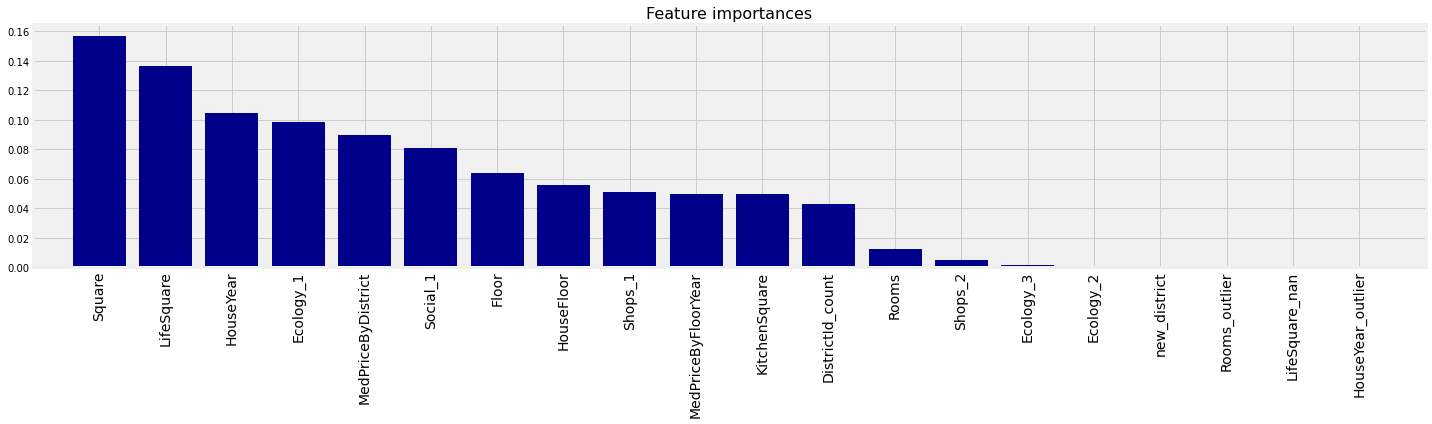

In [28]:
def plot_f_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_f_importances(importances = model.feature_importances_, X=X)

In [29]:
model.get_params

<bound method LGBMModel.get_params of LGBMRegressor(max_depth=33, min_samples_leaf=10, n_estimators=300,
              random_state=41)>

In [30]:
np.arange(0.01, 0.05, 0.01)

array([0.01, 0.02, 0.03, 0.04])

In [31]:
parameters = [{
    'max_bin': np.arange(90, 120, 10),
    'n_estimators': np.arange(4000, 7000, 1000),
    'learning_rate': np.arange(0.01, 0.05, 0.01)
}]

In [32]:
clf = GridSearchCV(
    estimator=LGBMRegressor(random_state=41),
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=4,
    n_jobs=-1,
)

In [33]:
clf.fit(X, y)

GridSearchCV(cv=4, estimator=LGBMRegressor(random_state=41), n_jobs=-1,
             param_grid=[{'learning_rate': array([0.01, 0.02, 0.03, 0.04]),
                          'max_bin': array([ 90, 100, 110]),
                          'n_estimators': array([4000, 5000, 6000])}],
             scoring='neg_mean_squared_error')

In [34]:
clf.best_params_

{'learning_rate': 0.01, 'max_bin': 90, 'n_estimators': 4000}

**8.Прогнозирование на тестовом датасете.**

In [35]:
model = LGBMRegressor(max_bin=110,
    n_estimators=4000,
    learning_rate=0.01)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=41))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.739 +- 0.018


In [36]:
model.fit(X, y)

LGBMRegressor(learning_rate=0.01, max_bin=110, n_estimators=4000)

In [37]:
y_pred_final = model.predict(X_final)
# test DATA Learn


preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head(10)

,Id,Price
0,4567,160238.297663
1,5925,122432.074029
2,960,140885.065961
3,3848,104976.625326
4,746,179502.601020
5,868,278171.675229
6,672,108100.847861
7,2471,207702.751957
8,4510,121917.645642
9,8354,227415.644036


In [38]:
preds_final.shape

(5000, 2)